##### Umer Muhammad
###### Group Assignment - Analysis and Modelling

### Installs and Imports

In [ ]:
# add the install flags
#
#!pip install seaborn
#!pip install nltk
#!pip install WordCloud
#!pip install seaborn
#

In [ ]:
#ensure you install openpyxl
# I'll move all the ad-hoc imports into this section later..
#
import numpy as np
np.set_printoptions(precision=2)
#
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# warnings
import warnings
warnings.filterwarnings('ignore')
#
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1, rc={'lines.linewidth': 2.5})
#
#
import nltk
#
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
#
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from wordcloud import WordCloud
#
#
from sklearn import model_selection
from sklearn import metrics
import time, datetime
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

#### Data Load

In [ ]:
retail = pd.read_excel('online_retail_normalized.xlsx')

#### Globals

In [ ]:
# I'll move all the ad-hoc globals into this section later..
#
random_state = 0
#
# countries
country_filter = []
#country_filter = ['United Kingdom'] #United Kingdom is the country that contributes the most to this dataset. May explore other countries after..
#country_filter = ['United Kingdom','Germany','France','EIRE']

#### Functions

In [ ]:
# I'll move all the ad-hoc functions into this section later..
# display null counts and % for df
def display_info(df):
    df_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
    df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
    df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
    display(df_info)
    display(df.sample(5, random_state=random_state))
    print(df.shape)


# nltk keywords tokenizer for given column
def get_keywords(dataframe, column):
    #
    nouns_found = lambda pos: pos[:2] == 'NN'
    #
    stemmer = nltk.stem.SnowballStemmer('english')
    keywords_roots  = dict()  # collect words / root
    keywords_select = dict()  # association: root to keyword
    keywords_count  = dict()
    category_keys   = []
    icount = 0
    #
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if nouns_found(pos)] 
        #
        for t in nouns:
            t = t.lower() ; root = stemmer.stem(t)
            if root in keywords_roots:                
                keywords_roots[root].add(t)
                keywords_count[root] += 1                
            else:
                keywords_roots[root] = {t}
                keywords_count[root] = 1
    #
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    key = k ; min_length = len(k)            
            category_keys.append(key)
            keywords_select[s] = key
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    #               
    print("Keywords found within feature '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, keywords_count

# plot keywords list; default limit 50
def plot_keywords(keywords_list, top_n = 50):
    # Plot
    plt.rc('font', weight='normal')
    fig, ax = plt.subplots(figsize=(7, 25))
    y_axis = [i[1] for i in keywords_list[:top_n]]
    x_axis = [k for k,i in enumerate(keywords_list[:top_n])]
    x_label = [i[0] for i in keywords_list[:top_n]]
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 13)
    plt.yticks(x_axis, x_label)
    plt.xlabel('Occurences', fontsize = 18, labelpad = 10)
    ax.barh(x_axis, y_axis, align = 'center')
    ax = plt.gca()
    ax.invert_yaxis()

    # title
    plt.title('Occurence of Keywords',bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
    #
    plt.show()
    
#
# plot silhouette and avg silhouette score
# ref: #https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def plot_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams['patch.force_edgecolor'] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    #
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = clusterer.fit_predict(X)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('For n_clusters = {}, the average silhouette_score is : {}'.format (n_clusters, silhouette_avg))
    #
    for i in range(n_clusters):
        # Aggregate -> Sort: silhouette scores for samples of cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap('Spectral')
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#  
# random colours
def rand_colour(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

#
# generate Word Cloud Visualization
def gen_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #
    wc = WordCloud(width=1000,height=400, background_color='lightgrey', max_words=1628,
                          relative_scaling=1,
                          color_func = rand_colour,
                          normalize_plurals=False,)
    wc.generate_from_frequencies(words)
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    plt.title('Cluster{}'.format(increment-1))  
#

#
# inspect explained variance
def inspect_pca(df, startpos, xlim):
    pca = PCA()
    pca_fitted = pca.fit(df)
    pca_samples = pca.transform(df)
    #
    fig, ax = plt.subplots(figsize=(14, 5))
    sns.set(font_scale=1)
    plt.step(range(startpos), pca.explained_variance_ratio_.cumsum(), where='mid', label='cumulative explained variance')
    sns.barplot(np.arange(1,startpos+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g', label='individual explained variance')
    plt.xlim(0, xlim)
    #
    ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])
    #
    plt.ylabel('Explained Variance', fontsize = 14)
    plt.xlabel('Principal components', fontsize = 14)
    plt.legend(loc='best', fontsize = 13);

    plt.show()  

#
# SpiderChart
# scale the data
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

# SpiderChart
# https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave-read-this
class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[0:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)
        
#
# fit and return Accuracy of prediction score using GridSearch Cross Validation
class fit_classifier(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        start = time.time()
        self.grid.fit(X, Y)
        end = time.time()
        duration = datetime.timedelta(seconds = end-start)
        print('Duration: {}'.format(duration))
        return duration
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        accuracy = accuracy_score(Y, self.predictions)
        print('Accuracy: {:.3%}'.format(accuracy))
        return accuracy
        #print("Accuracy: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        
        
#
# plot confusion matrix
def plot_cm(Y_test, Y_pred, title):
    plt.title('Confusion Matrix - {}'.format(title) )
    sns.heatmap(metrics.confusion_matrix(Y_test, Y_pred), annot=True, cmap='YlGn', fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
# 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
# plot the learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    #
    start = time.time()
    #
    plt.figure()
    plt.title(title)
    #
    if ylim is not None:
        plt.ylim(*ylim)
    #
    plt.xlabel('Training size')
    plt.ylabel('Accuracy score')
    #
    #train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, scoring='accuracy', n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring='accuracy', n_jobs=n_jobs, train_sizes=train_sizes)
    
    # train means, std
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    # test means, std
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # show grid
    plt.grid()
    
    # lines
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='CV score')
    
    # bands
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    
    #
    plt.tight_layout()
    plt.legend(loc='best')
    
    #
    end = time.time()
    print('Learning curve plot: {} to generate'.format(datetime.timedelta(seconds = end-start)))
    #
    return plt

### Explore

In [ ]:
# gives some infos on columns types and numer of null values
display_info(retail)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,TotalPrice
column type,int64,object,object,int64,datetime64[ns],float64,int64,object,int64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,TotalPrice
307476,573375,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-10-30 13:42:00,4.15,15521,United Kingdom,0,16.60
363856,578854,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,10,2011-11-27 11:15:00,2.08,14859,United Kingdom,0,20.80
228570,565779,22727,ALARM CLOCK BAKELIKE RED,4,2011-09-06 15:14:00,3.75,15804,United Kingdom,0,15.00
85093,547623,22979,PANTRY WASHING UP BRUSH,12,2011-03-24 11:29:00,1.45,15641,United Kingdom,0,17.40
157827,557109,21137,BLACK RECORD COVER FRAME,72,2011-06-16 16:06:00,3.39,15694,United Kingdom,0,244.08


(390453, 10)


#### Invoice Totals

In [ ]:
# Purchase total by CustomerID, InvoiceNo
tmp = retail.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
invoice_total = tmp.rename(columns = {'TotalPrice':'Inv_Total'})
#
# Add/Fill purchase dates (using mean)
retail['InvoiceDate_int'] = retail['InvoiceDate'].astype('int64')
tmp = retail.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
retail.drop('InvoiceDate_int', axis = 1, inplace = True)
invoice_total.loc[:, 'InvoiceDate'] = pd.to_datetime(tmp['InvoiceDate_int'])
#
# Only purchases with positive net value
invoice_total = invoice_total[invoice_total['Inv_Total'] > 0]
invoice_total.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Inv_Total,InvoiceDate
0,12347,537626,711.79,2010-12-07 14:57:00.000001024
1,12347,542237,475.39,2011-01-26 14:29:59.999999744
2,12347,549222,636.25,2011-04-07 10:42:59.999999232
3,12347,556201,382.52,2011-06-09 13:01:00.000000256
4,12347,562032,584.91,2011-08-02 08:48:00.000000000
5,12347,573511,1294.32,2011-10-31 12:25:00.000001280


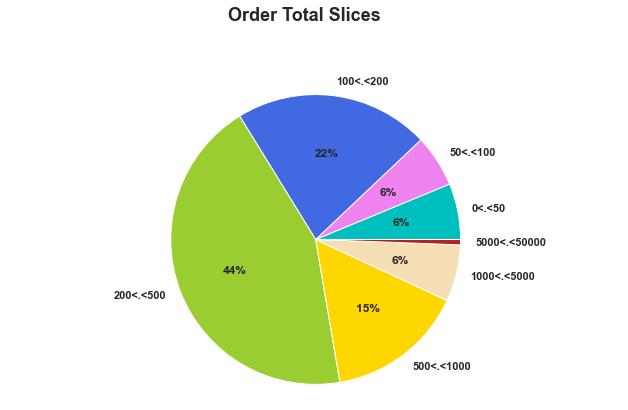

In [ ]:
# buckets for purchase totals
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
price_total = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = invoice_total[(invoice_total['Inv_Total'] < price) &
                       (invoice_total['Inv_Total'] > price_range[i-1])]['Inv_Total'].count()
    price_total.append(val)

# plot chart
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['c', 'violet', 'royalblue', 'yellowgreen', 'gold', 'wheat', 'firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = price_total
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, 'Order Total Slices', ha='center', fontsize = 18);

#### NLTK to discover and build Keyword libraries

##### Build Keyword Library

In [ ]:
products = pd.DataFrame(retail['Description'].unique()).rename(columns = {0:'Description'})
products[:5]

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.


In [ ]:
# Use Description column to develop possible keyword collections
keywords, keywords_roots, keywords_select, keywords_count = get_keywords(products, 'Description')

Keywords found within feature 'Description': 1476


In [ ]:
# Product list total by keyword occurences
product_list = []
for k,v in keywords_count.items():
    product_list.append([keywords_select[k],v])
product_list.sort(key = lambda x:x[1], reverse = True)

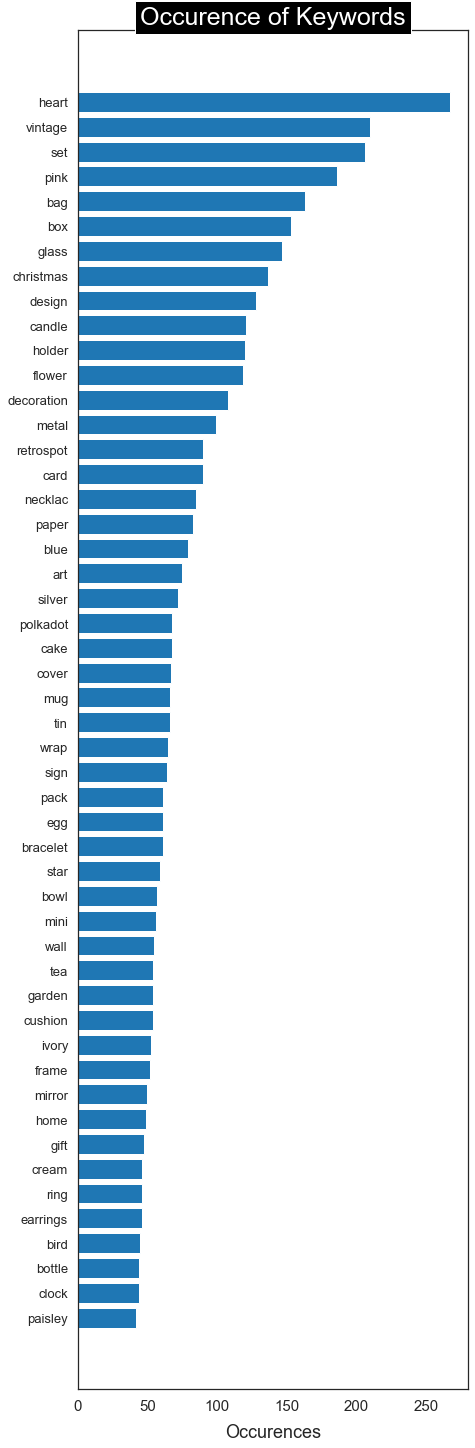

In [ ]:
# sort list
sorted_product_list = sorted(product_list, key = lambda x:x[1], reverse = True)

# show the top n product keywords
n_prod_keywords_to_show = 50 #125

# Plot
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in sorted_product_list[:n_prod_keywords_to_show]]
x_axis = [k for k,i in enumerate(sorted_product_list[:n_prod_keywords_to_show])]
x_label = [i[0] for i in sorted_product_list[:n_prod_keywords_to_show]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel('Occurences', fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

# title
plt.title('Occurence of Keywords',bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
#
plt.show()

#### Define Keyword Categories

##### Words we want to keep:
   - NOUNS; easily identify things
   - First we remove any strange descriptors or anything not really a noun...
     - this can be things you don't consider to be valid adjectives - it's debatable.
   - We also want to consider word lengths (eg. 'w' which probably means 'with' and this is just silly..)
   - We also want to keep possibly a certain threshold for occurences (such as more than 10 - try between 10-15)
   - want to skip any words where characters are used that may cause issues with data processing OR are causing mischief/bias towards the analysis

In [ ]:
product_list = []
for k,v in keywords_count.items():
    word = keywords_select[k]
    if word in ['tag', 'green', 'pink', 'blue', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    product_list.append([word, v])
#
product_list.sort(key = lambda x:x[1], reverse = True)
print('Words kept in keywords list:', len(product_list))

Words kept in keywords list: 189


Develop a matrix following principles of one-hot-encoding to determine which words occur in a given product description.

In [ ]:
# Let's generate a list of unique products using the Description column
#
list_of_products = retail['Description'].unique()
X = pd.DataFrame()
for key, occurence in product_list:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_of_products))
    
X.head(5)

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,toadstool,milk,funky,tidy,plant,house,square,lace,wallet,point
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Additional features such as price range may help minimize data points or with better labelling/groupings.

In [ ]:
#    
threshold = [0, 1, 2, 3, 5, 10]
labels = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    labels.append(col)
    X.loc[:, col] = 0
#
for i, prod in enumerate(list_of_products):
    price = retail[retail['Description'] == prod]['UnitPrice'].mean() # avg price of product
    j = 0
    while price > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, labels[j-1]] = 1
#  
X.head(5)

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,square,lace,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Product Counts by Range

In [ ]:
print("{:<8} {:<20} \n".format('Range', 'Product_Counts') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Range    Product_Counts       
--------------------
0<.<1       963                 
1<.<2       1007                
2<.<3       664                 
3<.<5       605                 
5<.<10      469                 
.>10        152                 


#### Create Product Clusters

##### Inspect initial clustering

Let's use Kmeans to cluster these products together and discover the ideal n_cluster value to use for creating Product Categories.

In [ ]:
#
n_clusters_range = range(3,15)
#
silhouette_avg_scores = []
n_elements_list = []
#
matrix = X.values
#
for n_clusters in n_clusters_range:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    #
    silhouette_avg_scores.append('{:.3%}'.format(silhouette_avg))
    n_elements_list.append(pd.Series(clusters).value_counts())
    #
    print(
        'n_cluster({}), Avg. Silhouette_score: {:.3%}'.format(
            n_clusters, silhouette_avg)
    )

# look at the elements counts
print('\nInspect Elements:')
for n_clusters in n_clusters_range:
    print(
        'n_cluster({}), \nn_elements: \n{}'.format(
            n_clusters, n_elements_list[n_clusters-n_clusters_range[0]]
        )
    )    

n_cluster(3), Avg. Silhouette_score: 10.311%
n_cluster(4), Avg. Silhouette_score: 12.844%
n_cluster(5), Avg. Silhouette_score: 14.895%
n_cluster(6), Avg. Silhouette_score: 14.675%
n_cluster(7), Avg. Silhouette_score: 14.469%
n_cluster(8), Avg. Silhouette_score: 15.025%
n_cluster(9), Avg. Silhouette_score: 14.713%
n_cluster(10), Avg. Silhouette_score: 15.353%
n_cluster(11), Avg. Silhouette_score: 13.273%
n_cluster(12), Avg. Silhouette_score: 12.924%
n_cluster(13), Avg. Silhouette_score: 14.560%
n_cluster(14), Avg. Silhouette_score: 13.254%

Inspect Elements:
n_cluster(3), 
n_elements: 
0    1890
2    1007
1     963
dtype: int64
n_cluster(4), 
n_elements: 
0    1226
2    1007
1     963
3     664
dtype: int64
n_cluster(5), 
n_elements: 
1    1007
3     963
4     757
0     664
2     469
dtype: int64
n_cluster(6), 
n_elements: 
2    915
5    891
0    619
4    580
1    556
3    299
dtype: int64
n_cluster(7), 
n_elements: 
0    1051
3     888
4     607
6     544
1     382
5     298
2      90


We can try testing with n_cluster = 5.
After n_cluster = 5 we observe more groupings of elements instead and lower counts of elements as well within their respective groupings, which may or may not be good (possibly double counting?).

##### Configure and Test n_clusters further

In [ ]:
# lets test with 5, as thats where we see some deviation in the number of elements and lower counts
n_clusters = 5
silhouette_avg = -1
#
silhouette_avg_scores = []
n_elements_list = []
#
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    #
    silhouette_avg_scores.append('{:.3%}'.format(silhouette_avg))
    n_elements_list.append(pd.Series(clusters).value_counts())
    #
    print(
        'n_cluster({}), Avg. Silhouette_score: {:.3%}'.format(
            n_clusters, silhouette_avg)
    )
    # look at the elements counts
    print('\nInspect Elements:')
    print(
        'n_cluster({}), \nn_elements: \n{}'.format(
            n_clusters, n_elements_list[n_clusters-n_clusters]
        )
    )

n_cluster(5), Avg. Silhouette_score: 14.915%

Inspect Elements:
n_cluster(5), 
n_elements: 
3    1007
0     963
1     664
4     621
2     605
dtype: int64


##### Plot Silhouette scores for each element of clusters

For n_clusters = 5, the average silhouette_score is : 0.14870493535892723


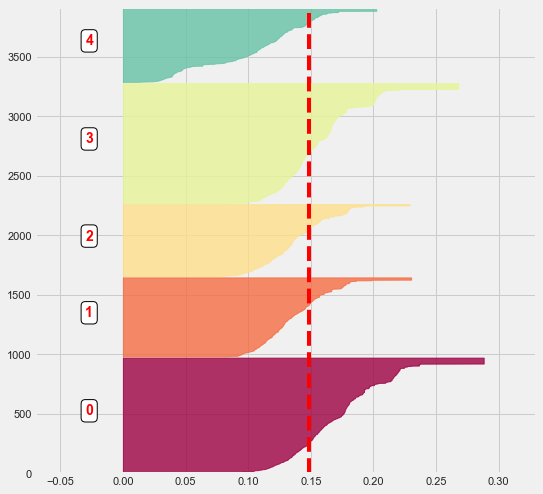

In [ ]:
#
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#
# and do the graph
plot_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

#### Word Cloud Visualization

Let's inspect the composition of the clusters.

In [ ]:
#
# Create a dataframe from the unique list of products we derived earlier
df_products = pd.DataFrame(list_of_products)
# get list of words 
list_keywords = [word for (word, occurence) in product_list]
#
list_keywords[:7]

['heart', 'vintage', 'set', 'bag', 'box', 'glass', 'christmas']

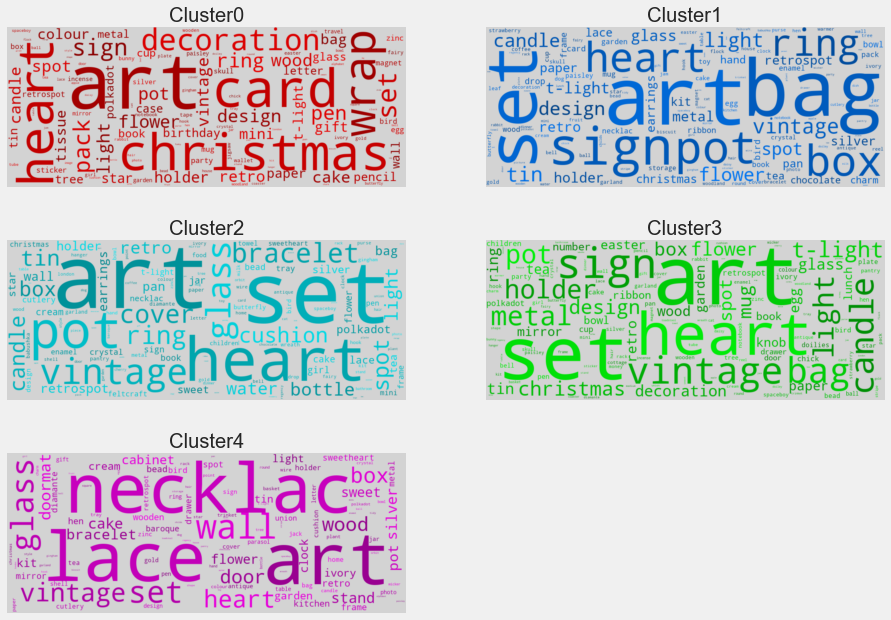

In [ ]:
#
n_clusters = 5
occurence = [dict() for _ in range(n_clusters)]
#
for i in range(n_clusters):
    list_cluster = df_products.loc[clusters == i]
    for word in list_keywords:
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))
#
#
#plot wordclouds for n_clusters
#
fig = plt.figure(1, figsize=(14,14))
#color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
color = [0, 150, 130, 87, 980, 70, 340, 130, 27]
for i in range(n_clusters):
    cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    gen_wordcloud(liste, i+1)

Totally need to remove some words that are not really a noun (eg. art, tag, heart, set)
Some colours too should removed (blue, pink) as we saw in the bar chart earlier. Pink made up a huge count and that might sound like a good number, but the object associated with it most likely being counted already - therefore the inclusion of pink as a label might cause issues.

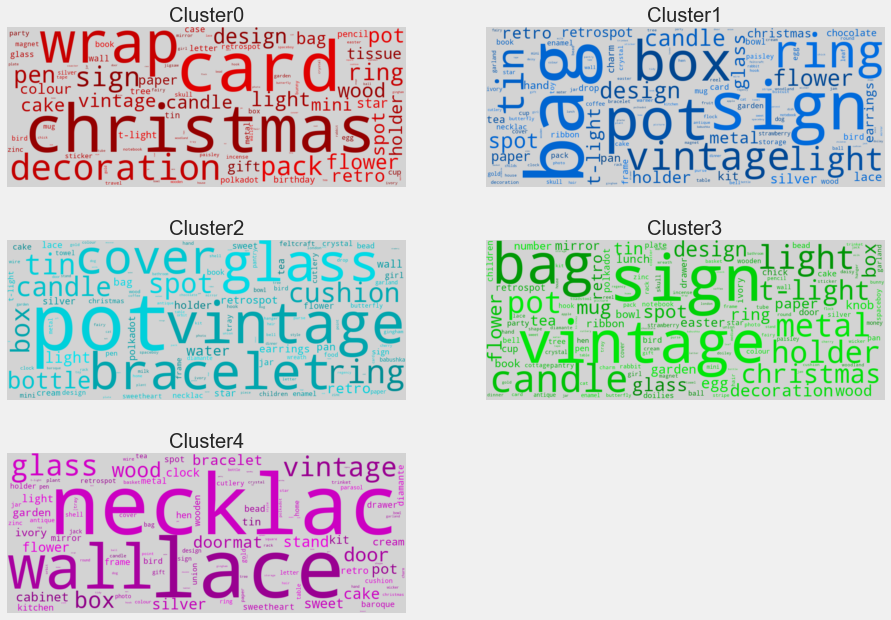

In [ ]:
#
n_clusters = 5
occurence = [dict() for _ in range(n_clusters)]
#
for i in range(n_clusters):
    list_cluster = df_products.loc[clusters == i]
    for word in list_keywords:
        if word in ['art', 'tag', 'set', 'heart', 'blue', 'pink']: continue
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))
#
#plot wordclouds for n_clusters
#
fig = plt.figure(1, figsize=(14,14))
#color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
color = [0, 150, 130, 87, 980, 70, 340, 130, 27]
for i in range(n_clusters):
    cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    gen_wordcloud(liste, i+1)

Looks so much better, and doesn't feel like there are overlaps between the clusters. We can evaluate this further..

### Further validate distinctness in clusters

#### Cluster composition inspection via PCA visualization

There are so many keywords that scaling or creating a more appropriate matrix may help in analysis or model building.
PCA is good for reducing/scalinng dimensions and possibly identifying key features.

In [ ]:
# There are so many keywords but lets limit n_components to a smaller number
pca = PCA(n_components=50)
mat_pca = pca.fit_transform(matrix)
mat = pd.DataFrame(mat_pca)
mat['cluster'] = pd.Series(clusters)

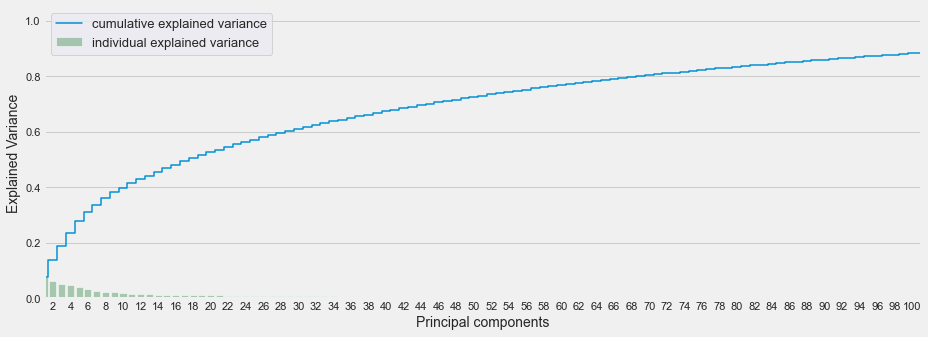

In [ ]:
# Apply pca to inspect explained variance
inspect_pca(matrix, matrix.shape[1], 100)

.... basically 100+ components to do 95-99% ExVar. May not really be surprising given the number of product categories that we have.

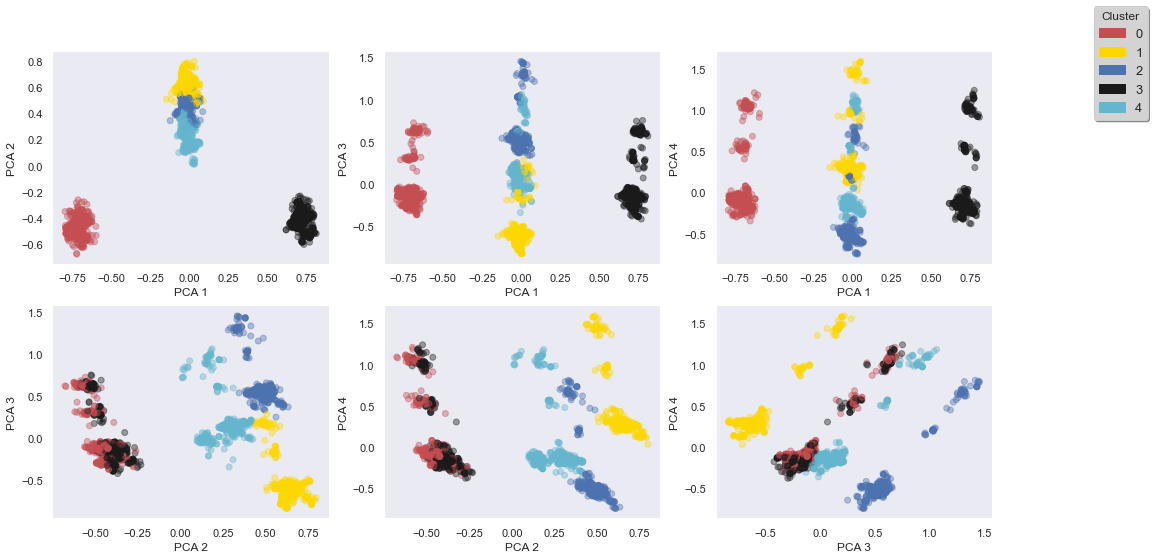

In [ ]:
import matplotlib.patches as mpatches

lbl_clr_map = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
lbl_clr = [lbl_clr_map[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c=lbl_clr, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#
# legend
cmap_handle = []
for i in range(5):
    cmap_handle.append(mpatches.Patch(color = lbl_clr_map[i], label = i))

plt.legend(handles=cmap_handle, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

PCA1 shows some really good distinct clumping.

### Customer Labels/Customer Categorization

#### Format and Add data to original data frame

The purpose of this section is to amalgamate all the data into a flatter version of itself. Aggregation of the order details into one line, invoice total, and the distributions between product categories.

In [ ]:
retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34


In [ ]:
# First we create links using our unique list of products from earlier to their possible respective category clusters.
#
links = dict()
for key, val in zip (list_of_products, clusters):
    links[key] = val 
#
# Map the Product Category the record belongs to based o
retail['product_category'] = retail.loc[:, 'Description'].map(links)
#
#
retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,TotalPrice,product_category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,2


In [ ]:
# I don't want to keep writing this text again and again...
prod_cat_n = 'prod_cat_{}'
#
for i in range(n_clusters):
    col = prod_cat_n.format(i)        
    df_temp = retail[retail['product_category'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['CancelledQuantity'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    retail.loc[:, col] = price_temp
    retail[col].fillna(0, inplace = True)
#
#
retail[['InvoiceNo', 'Description', 'product_category', 'prod_cat_0', 'prod_cat_1', 'prod_cat_2', 'prod_cat_3','prod_cat_4']][:5]

,InvoiceNo,Description,product_category,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.0,15.3,0.00,0.0,0.0
1,536365,WHITE METAL LANTERN,2,0.0,0.0,20.34,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,2,0.0,0.0,22.00,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2,0.0,0.0,20.34,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2,0.0,0.0,20.34,0.0,0.0


Now that we have totals by product_category order detail lines for each invoice, we can aggregate the product category distributions for each invoice as a single record.
The matrix now can describe characteristics in a more meaningful manner. We also include the invoice date so we can use this data for our model, by splitting it based on time we can approach it as an attempt to predict the future rather than some asbtract prediction.

In [ ]:
# Create a new Dataframe to Group Invoice totals by CustomerID, InvoiceNo
# Add the product category columns as well as this is meant to be a single record representing the entire Invoice
tmp = retail.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
invoice_total = tmp.rename(columns = {'TotalPrice':'Invoice_Total'})
for i in range(n_clusters):
    col = prod_cat_n.format(i)
    invoice_total[col] = 0
#
#
# Add Product Category Totals by CustomerID and InvoiceNo
for i in range(n_clusters):
    col = prod_cat_n.format(i) 
    tmp = retail.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    invoice_total.loc[:, col] = tmp 
#
#
# Add/Fill purchase dates (using mean)
retail['InvoiceDate_int'] = retail['InvoiceDate'].astype('int64')
tmp = retail.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
retail.drop('InvoiceDate_int', axis = 1, inplace = True)
invoice_total.loc[:, 'InvoiceDate'] = pd.to_datetime(tmp['InvoiceDate_int'])
#
# Select only invoices with positive net value
invoice_total = invoice_total[invoice_total['Invoice_Total'] > 0]
invoice_total.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Invoice_Total,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4,InvoiceDate
0,12347,537626,711.79,23.40,83.40,293.35,187.2,124.44,2010-12-07 14:57:00.000001024
1,12347,542237,475.39,84.34,53.10,169.20,130.5,38.25,2011-01-26 14:29:59.999999744
2,12347,549222,636.25,81.00,71.10,115.00,330.9,38.25,2011-04-07 10:42:59.999999232
3,12347,556201,382.52,41.40,78.06,168.76,74.4,19.90,2011-06-09 13:01:00.000000256
4,12347,562032,584.91,61.30,119.70,158.16,109.7,136.05,2011-08-02 08:48:00.000000000


##### Train/Test by Time (10 months / 2 months):

In [ ]:
# Separate data by time
print(invoice_total['InvoiceDate'].min(), '->',  invoice_total['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [ ]:
# Cut off date for Train/Test data, since it is a years worth of data starting in december of 2010
# we can choose October 1st of 2011 to cut off the data, giving us November and December to train....
# desire that dataset be larger than a years worth...its not enough in my opinion..
cutoff_date = '10/01/2011'
#
train_set = invoice_total[invoice_total['InvoiceDate'] < pd.to_datetime(cutoff_date)]
test_set = invoice_total[invoice_total['InvoiceDate'] >= pd.to_datetime(cutoff_date)]
#
invoice_total = train_set.copy()

display_info(invoice_total)

,CustomerID,InvoiceNo,Invoice_Total,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4,InvoiceDate
column type,int64,int64,float64,float64,float64,float64,float64,float64,datetime64[ns]
null values (nb),0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,CustomerID,InvoiceNo,Invoice_Total,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4,InvoiceDate
13069,16549,562593,660.87,143.06,165.61,53.55,233.60,65.05,2011-08-07 15:43:00.000002304
9359,15214,568213,305.12,15.51,178.98,19.80,39.48,51.35,2011-09-25 16:06:00.000000000
16147,17581,545591,356.90,62.90,187.50,19.50,87.00,0.00,2011-03-04 10:28:00.000000000
16853,17790,538190,127.90,10.40,53.15,0.00,38.85,25.50,2010-12-10 10:47:00.000000000
6315,14309,543045,207.22,6.72,50.70,31.60,47.40,70.80,2011-02-03 09:04:00.000000000


(13104, 9)


##### Customer Total Order Counts/Min/Max/Mean and Product Category distributions

We already have invoice totals and their respective appropriate information. We can take this further and find their min/max/mean/counts values.

In [ ]:
#
# Get total Customer Transaction Counts min/max/avg spending and their product category distributions
customer_transactions = invoice_total.groupby(by=['CustomerID'])['Invoice_Total'].agg(['count','min','max','mean','sum'])
for i in range(n_clusters):
    col = prod_cat_n.format(i)
    customer_transactions.loc[:,col] = invoice_total.groupby(by=['CustomerID'])[col].sum() / customer_transactions['sum']*100

#
customer_transactions.reset_index(drop = False, inplace = True)
#
display(invoice_total.groupby(by=['CustomerID'])['prod_cat_0'].sum())
customer_transactions.sort_values('CustomerID', ascending = True).sample(5)

CustomerID
12347    291.44
12348    683.24
12350     39.10
12352     10.20
12353      0.00
          ...  
18280      0.00
18281     15.12
18282     19.11
18283    186.98
18287     40.68
Name: prod_cat_0, Length: 3608, dtype: float64

,CustomerID,count,min,max,mean,sum,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4
1965,15517,1,267.03,267.03,267.030,267.03,25.648804,20.503314,8.051530,41.021608,4.774744
2583,16557,1,101.15,101.15,101.150,101.15,0.000000,0.000000,37.963421,0.000000,62.036579
2142,15813,2,533.26,770.65,651.955,1303.91,6.607818,21.282144,20.231458,22.754638,29.123943
2186,15894,2,106.81,151.44,129.125,258.25,14.172314,6.950629,47.279768,16.766699,14.830591
2051,15665,2,765.79,1456.42,1111.105,2222.21,22.793075,17.964999,4.088272,43.939592,11.214062


Let's determine their first and last purchase dates. This includes customers with single purchases as well. Something the business may want to focus on.
By determining their first and last purchase, we can try to predict the next purchase based on any customers first purchase...or atleast this is goal.
This considers all the different product categories the customer may have touched over their current life time, and still approaches this from first/last purchase point of view.

In [ ]:
# calc first and last purchase dates
max_date = invoice_total['InvoiceDate'].max().date()

first_purchase = pd.DataFrame(invoice_total.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(invoice_total.groupby(by=['CustomerID'])['InvoiceDate'].max())
#
test  = first_purchase.applymap(lambda x:(max_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(max_date - x.date()).days)
#
customer_transactions.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
customer_transactions.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']
#
customer_transactions.sample(5)

,CustomerID,count,min,max,mean,sum,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4,LastPurchase,FirstPurchase
1551,14849,17,17.40,813.89,338.721765,5758.27,20.571109,16.844816,17.853453,29.337978,15.392644,25,303
383,12942,3,137.77,279.08,225.200000,675.60,3.336294,10.327117,25.932504,14.511545,45.892540,61,295
1569,14875,2,358.10,1099.57,728.835000,1457.67,3.943279,15.109044,23.866856,19.812440,37.268380,37,192
1376,14541,7,38.30,307.91,186.764286,1307.35,5.469844,24.148086,40.008414,24.828087,5.545569,98,249
306,12820,2,170.46,217.77,194.115000,388.23,30.291322,37.652938,16.652500,15.403240,0.000000,4,256


In [ ]:
# As mentioned earlier, we wanted to capture customers that are single purchase only
n1 = customer_transactions[customer_transactions['count'] == 1].shape[0]
n2 = customer_transactions.shape[0]
print("Customers with only one purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

Customers with only one purchase: 1443/3608  (39.99%)


There is a huge majority of single purchase customers. These could be returning customers purchasing as a guest for all we know. It is possible that this years worth of data does not truly represent the business life over several years. There are many inferences we can make and they may be false, however, we want to bring light to this portion of the data being single purchase customers and some food for thought: is there a way to have them be returning customers?

### Customer Categories

Let's categorize the customers 

In [ ]:
# generate feature column list
from sklearn.preprocessing import StandardScaler
#
feature_cols = ['count','min','max','mean']
category_cols = []
n_prod_cat = n_clusters
# to save some time I will just cast these to an array/list.
for i in range (n_prod_cat):
    category_cols.append(prod_cat_n.format(i))
    #feature_cols.append(prod_cat_n.format(i))

#
#
# Matrix and Scale values
df_customers = customer_transactions.copy()
matrix = customer_transactions[feature_cols + category_cols].values
scaler = StandardScaler()
fitted_matrix = scaler.fit(matrix)
print('Variables means: \n', scaler.mean_)
#
scaled_matrix = fitted_matrix.transform(matrix)

Variables means: 
 [  3.63 259.5  566.23 380.58  13.98  21.19  16.37  25.25  23.21]


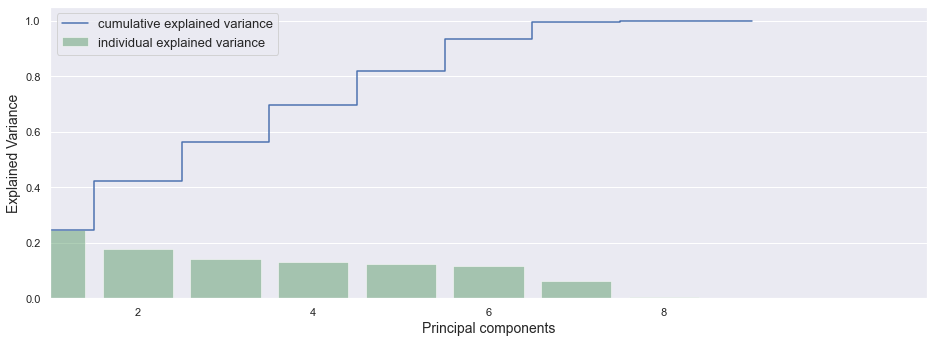

In [ ]:
# Apply pca to inspect explained variance
inspect_pca(scaled_matrix, matrix.shape[1], 10)

In [ ]:
# Inspect Customer Counts in each Cluster
n_clusters_range = range(3,15)
#
for n_clusters in n_clusters_range:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(scaled_matrix)
    clustered_customers = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clustered_customers)
    #
    print(
        'n_cluster({}), Avg. Silhouette_score: {}'.format(
            n_clusters, silhouette_avg
        )
    )
    #
    display(pd.DataFrame(pd.Series(clustered_customers).value_counts(), columns = ['customer_counts']).T)
    #

n_cluster(3), Avg. Silhouette_score: 0.15869554603841296


,2,1,0
customer_counts,2136,1448,24


n_cluster(4), Avg. Silhouette_score: 0.1673549026418202


,1,0,3,2
customer_counts,2094,1382,124,8


n_cluster(5), Avg. Silhouette_score: 0.17938250958358246


,4,1,3,0,2
customer_counts,1410,1358,709,123,8


n_cluster(6), Avg. Silhouette_score: 0.17665282028585183


,0,4,2,3,1,5
customer_counts,1183,916,755,632,114,8


n_cluster(7), Avg. Silhouette_score: 0.19760157888189367


,4,0,2,1,5,6,3
customer_counts,1382,691,633,528,265,101,8


n_cluster(8), Avg. Silhouette_score: 0.2014866346468171


,2,6,7,0,3,4,5,1
customer_counts,1198,785,632,617,236,98,36,6


n_cluster(9), Avg. Silhouette_score: 0.2084091465132068


,6,4,1,8,0,2,3,7,5
customer_counts,1562,537,462,349,329,232,100,31,6


n_cluster(10), Avg. Silhouette_score: 0.21305524807336731


,1,0,4,5,8,6,7,9,2,3
customer_counts,1496,535,468,347,297,229,194,23,12,7


n_cluster(11), Avg. Silhouette_score: 0.21679378386881681


,9,6,0,2,7,4,1,8,10,5,3
customer_counts,1445,523,453,323,292,226,178,145,9,8,6


n_cluster(12), Avg. Silhouette_score: 0.21949556986417265


,9,1,0,2,7,5,10,6,3,4,8,11
customer_counts,1437,504,456,310,299,229,182,160,12,10,7,2


n_cluster(13), Avg. Silhouette_score: 0.2009688314741819


,1,5,6,7,2,0,10,12,9,4,8,11,3
customer_counts,1140,654,384,330,284,247,240,163,106,40,10,8,2


n_cluster(14), Avg. Silhouette_score: 0.19246363146281822


,3,10,7,4,8,0,12,2,1,6,11,13,9,5
customer_counts,886,693,520,339,323,235,179,157,146,98,12,10,8,2


In [ ]:
# Anywhere between 9-11 looks good, 12 is dismissed because there is a clustering count of 2 which is undesirable
# We can select 11 as that is the best Avg.Silhouette Score before we start scoring lower or start clustering lower counts of products due to more clusters.
#
n_clusters = 11
#
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clustered_customers = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clustered_customers)
print(
    'n_cluster({}), Avg. Silhouette_score: {}'.format(
        n_clusters, silhouette_avg)
     )

#pd.DataFrame(pd.Series(clustered_customers).value_counts(), columns = ['customer_counts']).sort_index().T
pd.DataFrame(pd.Series(clustered_customers).value_counts(), columns = ['customer_counts']).T

n_cluster(11), Avg. Silhouette_score: 0.21702047143461195


,1,4,9,5,0,7,8,3,6,10,2
customer_counts,1450,520,450,323,295,229,166,152,8,8,7


The clusters have bucketed customer counts appropriately without having extremely low counts such as 5 and lower for example.
However, there is still so much disparity between them. We should ensure these clusters have uniqueness to them and can explain most of the data.

Visualize using PCA

In [ ]:
#
# let's utilize PCA to visualize ExVar
#
n_components = 6
pca = PCA(n_components = n_components)
mat_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(mat_3D)
mat['cluster'] = pd.Series(clustered_customers)

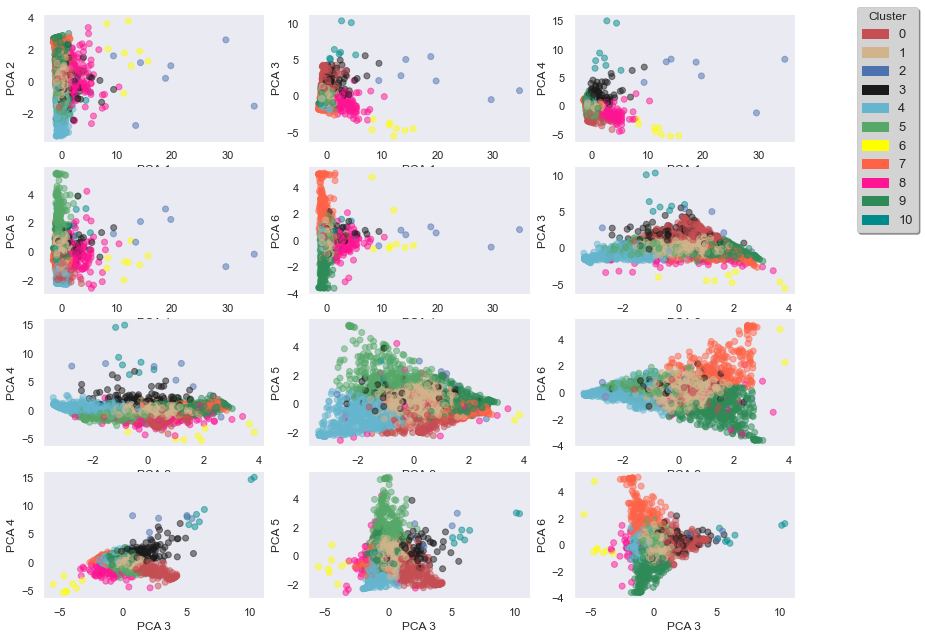

In [ ]:
#
lbl_clr_map = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'yellow', 7:'tomato', 8:'deeppink', 9:'seagreen', 10:'darkcyan', 11:'skyblue', 12:'orange'}
lbl_clr = [lbl_clr_map[l] for l in mat['cluster']]
#
fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(n_components):
    for iy in range(ix+1, n_components):
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= lbl_clr, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == (n_components * 2): break
    if increment == (n_components * 2): break
        
# legend
cmap_handle = []
for i in range(n_clusters):
    cmap_handle.append(mpatches.Patch(color = lbl_clr_map[i], label = i))

plt.legend(handles=cmap_handle, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

For n_clusters = 11, the average silhouette_score is : 0.13474869606632112


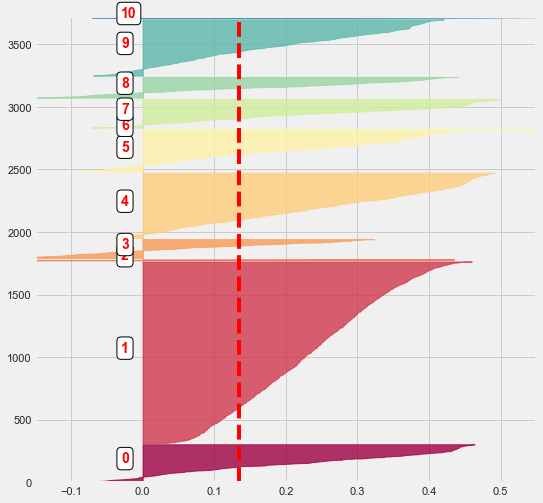

In [ ]:
# Inspect Silhouette values again..
#
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clustered_customers)
#
# and do the graph
plot_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clustered_customers)

Clusters appear to have some uniqueness.

#### Customer Morphology and Spidercharts/Radarcharts

We can use our chosen customers and their respective clusters to better understand their behaviours.

In [ ]:
#
df_customers.loc[:, 'cluster'] = clustered_customers
#
df_merged = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(df_customers[df_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = df_customers[df_customers['cluster'] == i].shape[0]
    df_merged = pd.concat([df_merged, test])
#
df_merged.drop('CustomerID', axis = 1, inplace = True)
print('Customer counts:', df_merged['size'].sum())
#
df_merged = df_merged.sort_values('sum')

Customer counts: 3608


Sort customers by highest spending category, then by Inovice Total

In [ ]:
# Resort by Amount spent in each category then by TotalAmount
#
add_info_cols = ['cluster','size','sum']
index_list = []
for i in range(5):
    column = prod_cat_n.format(i)
    index_list.append(df_merged[df_merged[column] > 45].index.values[0])
#
index_list_sorted = index_list
index_list_sorted += [ s for s in df_merged.index if s not in index_list]
#
df_merged = df_merged.reindex(index = index_list_sorted)
df_merged = df_merged.reset_index(drop = False)
display(df_merged[add_info_cols + feature_cols + category_cols])

,cluster,size,sum,count,min,max,mean,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4
0,7.0,229,581.458821,2.183406,193.508952,317.790961,246.532033,57.747114,10.981296,6.026865,17.984949,7.259776
1,0.0,295,811.386339,2.596610,207.566847,373.350678,286.808496,6.898098,60.812685,7.116883,14.906235,10.266100
2,5.0,323,667.457276,2.117647,213.003437,344.401889,272.900363,6.465985,14.090346,49.597752,13.461033,16.384885
3,9.0,450,654.795713,2.402222,216.885178,326.178958,269.182080,12.885554,12.708933,7.458774,57.696125,9.250615
4,4.0,520,721.958156,2.646154,198.900137,348.708135,263.263309,4.929229,11.097639,11.026520,11.228111,61.718500
5,1.0,1450,1118.509242,3.289655,223.579277,470.733152,337.378418,14.166337,22.130572,17.100599,26.234845,20.367648
6,8.0,166,2368.684946,1.638554,1128.890060,1547.477898,1323.516229,11.699536,21.592123,17.101167,25.444114,24.163061
7,6.0,8,5328.398750,1.250000,4056.488750,4239.456250,4147.972500,29.667052,12.110388,15.646832,22.279994,20.295734
8,3.0,152,10641.761842,18.414474,84.248092,1732.783487,595.363191,12.250633,25.284935,16.397255,23.936946,22.130231
9,10.0,8,38026.088750,87.375000,29.182500,2645.456250,461.706538,11.429542,24.842358,13.893198,25.078559,24.756343


#### Spiderchart plotting

Here we will visualize using Spider/Radarcarts to visualize the customer behavior within each cluster.

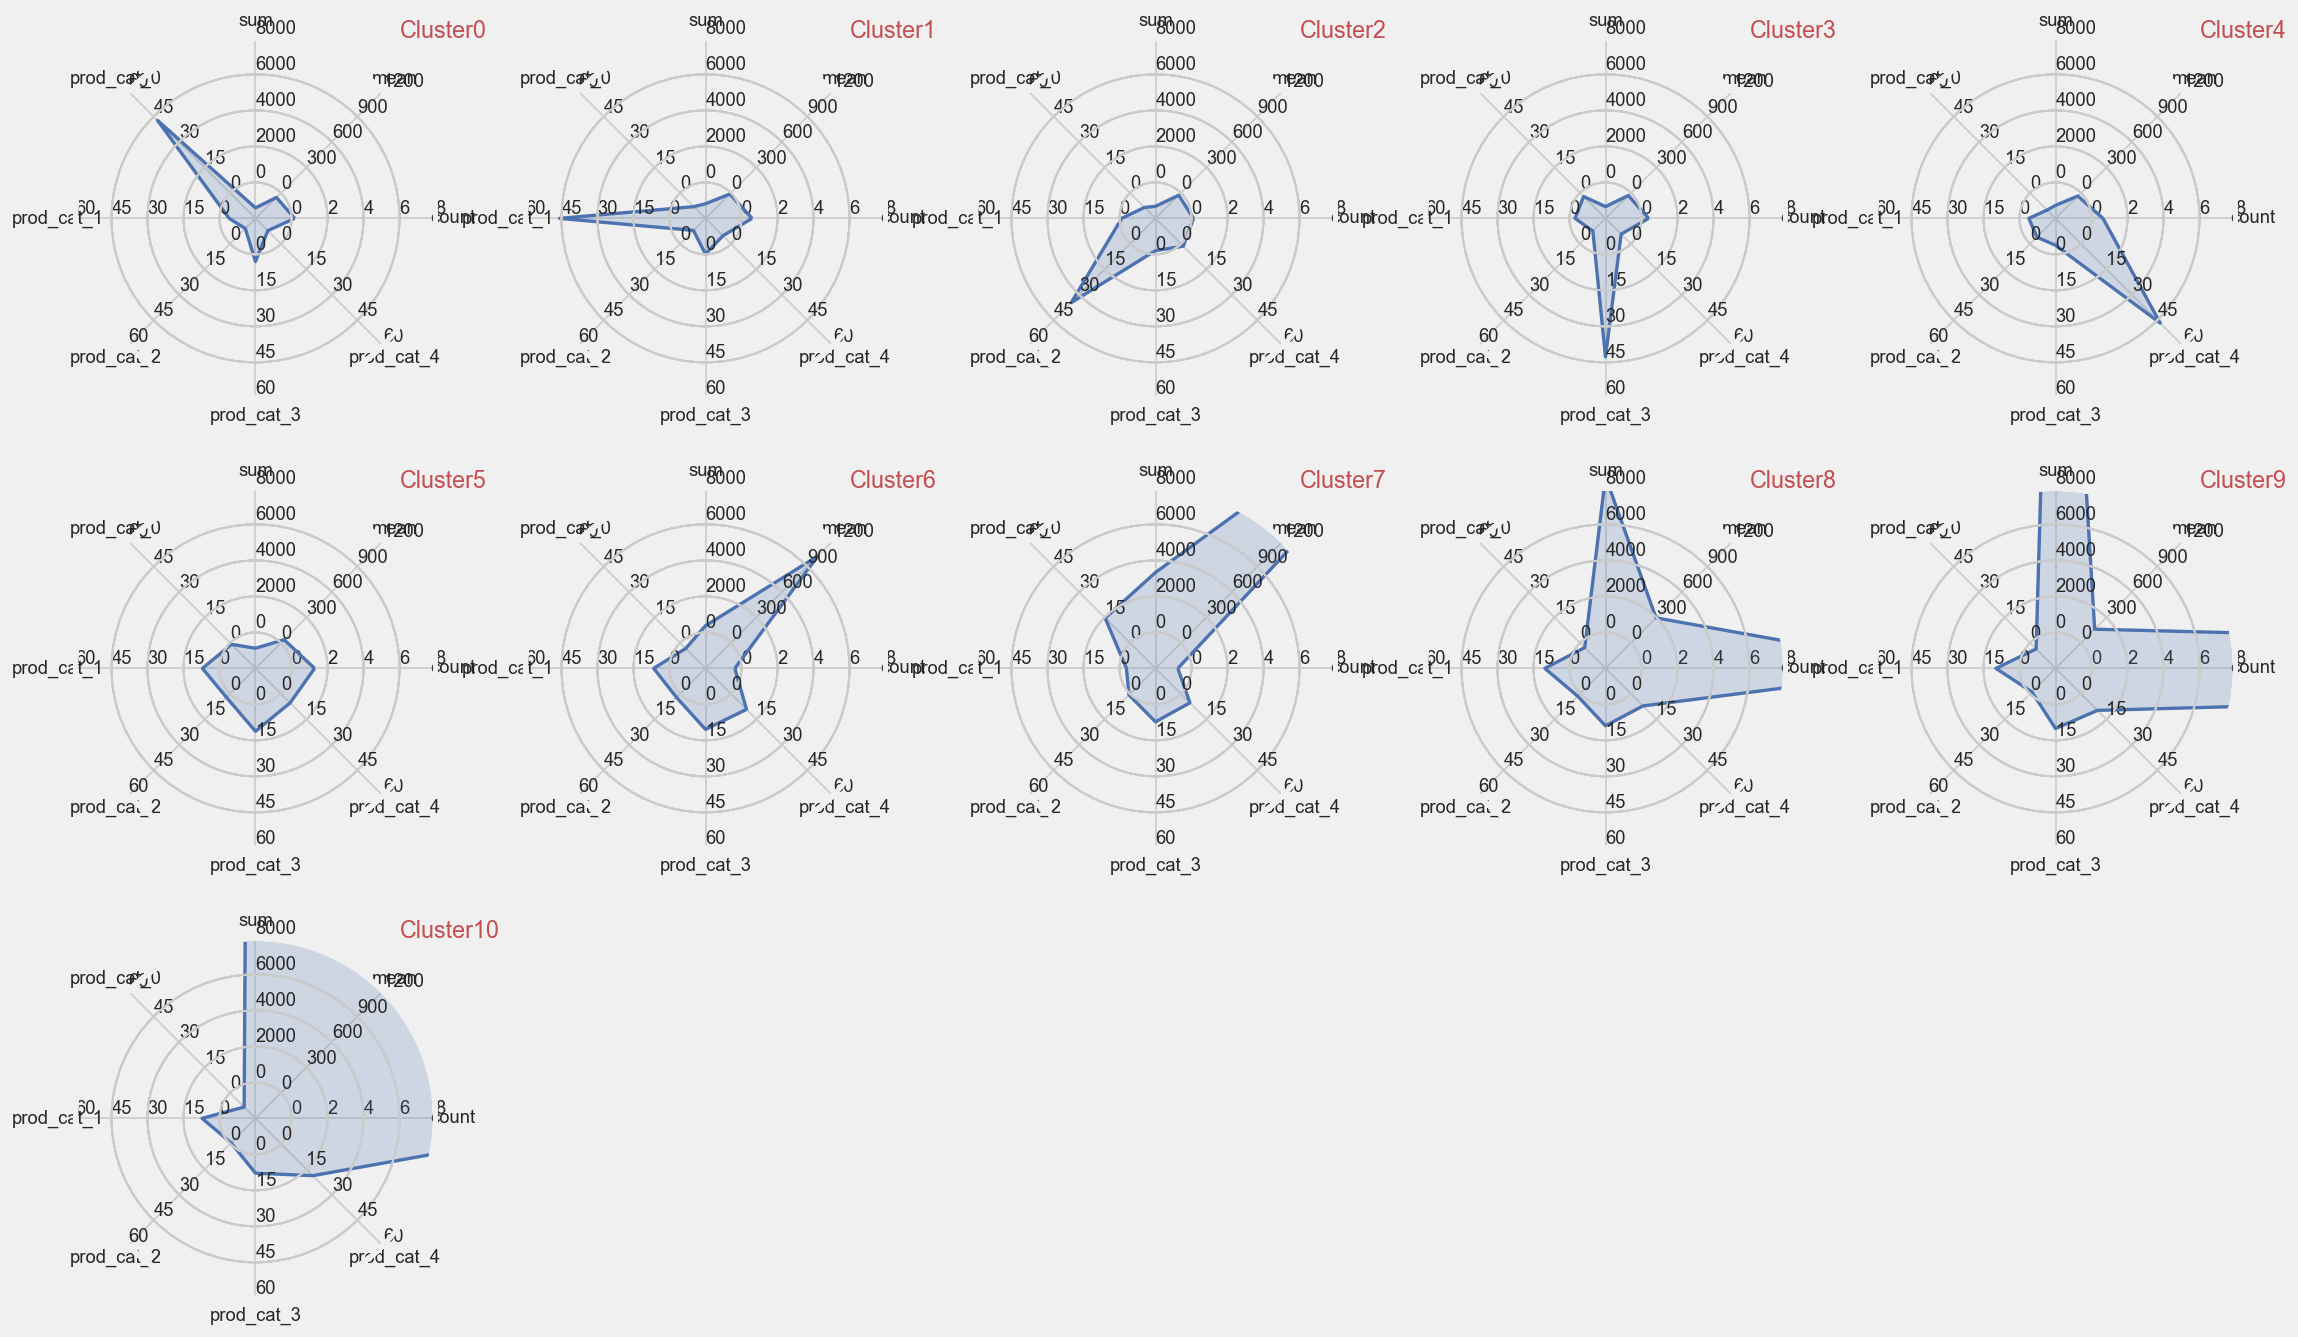

In [ ]:
fig = plt.figure(figsize=(15,15), dpi=120)

attributes = ['count', 'mean', 'sum'] + category_cols
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = np.arange(0, n_clusters + 2)

n_groups = n_clusters
i_cols = 5
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for idx in range(n_clusters):
    ix = idx%i_cols
    iy = i_rows - idx//i_cols
    pos_x = ix*(size_x + 0.05)
    #pos_y = iy*(size_y + 0.05)
    pos_y = iy*(size_y - 0.25)
    location = [pos_x, pos_y]
    sizes = [size_x, size_y]
    #
    data = np.array(df_merged.loc[index[idx], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'Cluster{}'.format(index[idx]), color = 'r')
    idx += 1

The first five clusters show purchases predominantly belonging to specific product categories. Then we also see further distributions regarding counts/means/sums.

Count = Total Invoice Orders

Mean = Invoice Avg.

Sum = Total Customer Spend


### Model Building - Predicting Customer Classifications

##### Train/Test Set

In [ ]:
#
# Preprocessing steps for Model Building
train_size = 0.8
columns = ['mean'] + category_cols
#
X = df_customers[columns]
Y = df_customers['cluster']
#
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = train_size)

##### Params/Variables/Globals

In [ ]:
# globals
train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ylim = [1.01, 0.6]
cv = 5
Kfold = 5
n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_estimators_by20 = [20, 40, 60, 80, 100]

### Learning Curve Evaluation

#### SVC

Duration: 0:00:17.782348
Accuracy: 84.626%


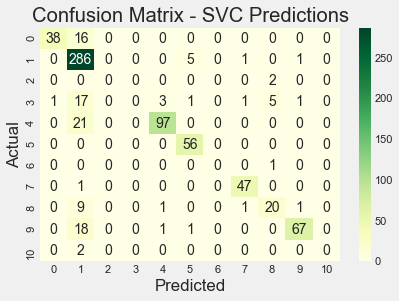

Learning curve plot: 0:00:08.170289 to generate
0:00:17.782348
0.8462603878116344


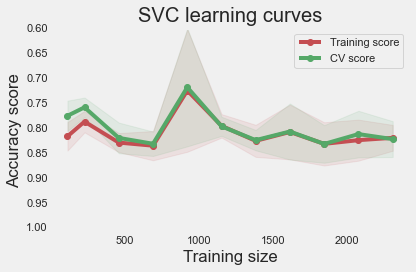

In [ ]:
# SVC
from sklearn.svm import SVC
from sklearn import svm
#
title = 'SVC'
#
svc = fit_classifier(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
duration = svc.grid_fit(X = X_train, Y = Y_train)
accuracy = svc.grid_predict(X_test, Y_test)
# Confusion Matrix
plt.title('Confusion Matrix - ' + title + ' Predictions')
sns.heatmap(metrics.confusion_matrix(Y_test, svc.predictions), annot=True, cmap='YlGn', fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# Learning Curves
svc_lc = plot_learning_curve(svc.grid.best_estimator_, title + ' learning curves', X_train, Y_train, ylim = ylim, cv = cv, train_sizes = train_sizes)
print(duration)
print(accuracy)

#### Logistic Regression

Duration: 0:00:10.969537
Accuracy: 90.305%


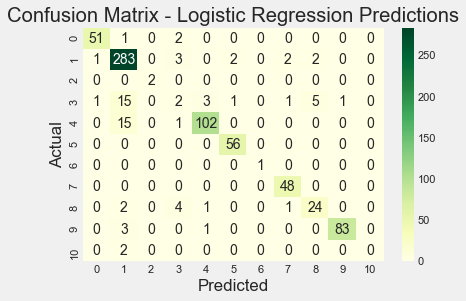

Learning curve plot: 0:00:03.548757 to generate


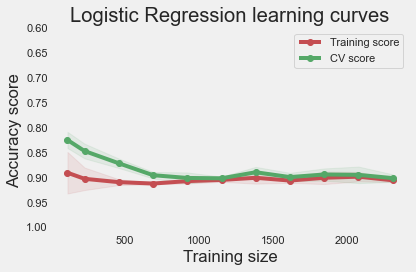

In [ ]:
#
from sklearn import linear_model
#
title = 'Logistic Regression'
#
logreg = fit_classifier(clf = linear_model.LogisticRegression)
logreg.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = Kfold)
logreg.grid_fit(X = X_train, Y = Y_train)
logreg.grid_predict(X_test, Y_test)
# Confusion Matrix
plt.title('Confusion Matrix - ' + title + ' Predictions')
sns.heatmap(metrics.confusion_matrix(Y_test, logreg.predictions), annot=True, cmap='YlGn', fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# Learning Curves
logreg_lc = plot_learning_curve(logreg.grid.best_estimator_, title + ' learning curves', X_train, Y_train, ylim = ylim, cv = cv, train_sizes = train_sizes)

#### KNN

Duration: 0:00:05.582898
Accuracy: 81.163%


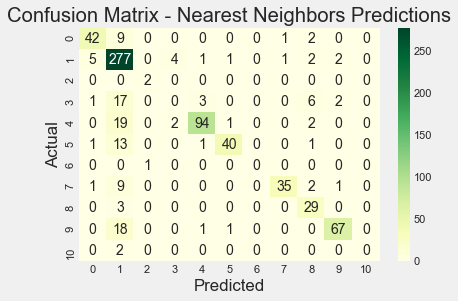

Learning curve plot: 0:00:02.748361 to generate


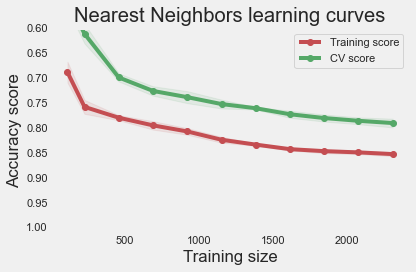

In [ ]:
#
from sklearn import neighbors
#
title = 'Nearest Neighbors'
#
knn = fit_classifier(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = Kfold)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)
# Confusion Matrix
plt.title('Confusion Matrix - ' + title + ' Predictions')
sns.heatmap(metrics.confusion_matrix(Y_test, knn.predictions), annot=True, cmap='YlGn', fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# Learning Curves
knn_lc = plot_learning_curve(knn.grid.best_estimator_, title + ' learning curves', X_train, Y_train, ylim = ylim, cv = cv, train_sizes = train_sizes)

#### Decision Tree

Duration: 0:00:00.215389
Accuracy: 83.102%


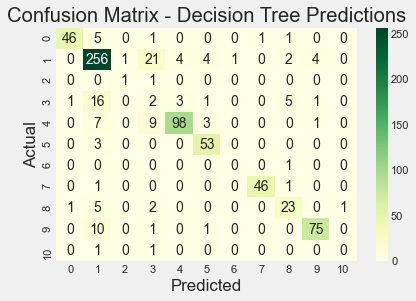

Learning curve plot: 0:00:00.397347 to generate


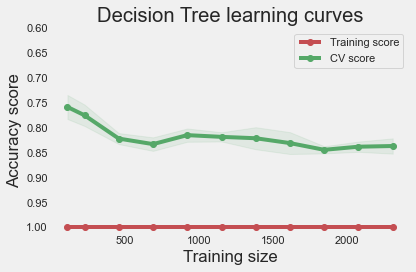

In [ ]:
#
from sklearn import tree
#
title = 'Decision Tree'
#
m_tree = fit_classifier(clf = tree.DecisionTreeClassifier)
m_tree.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = Kfold)
m_tree.grid_fit(X = X_train, Y = Y_train)
m_tree.grid_predict(X_test, Y_test)
# Confusion Matrix
plt.title('Confusion Matrix - ' + title + ' Predictions')
sns.heatmap(metrics.confusion_matrix(Y_test, m_tree.predictions), annot=True, cmap='YlGn', fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# Learning Curves
m_tree_lc = plot_learning_curve(m_tree.grid.best_estimator_, title + ' learning curves', X_train, Y_train, ylim = ylim, cv = cv, train_sizes = train_sizes)

#### Random Forest

Duration: 0:00:58.485986
Accuracy: 90.859%


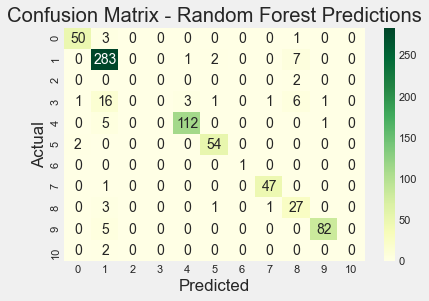

Learning curve plot: 0:00:18.419427 to generate


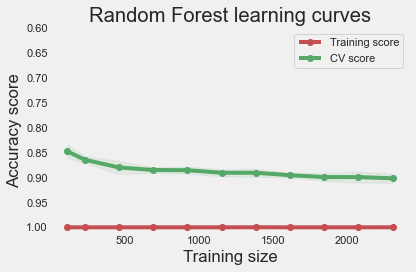

In [ ]:
#
from sklearn import ensemble
#
title = 'Random Forest'
#
rand_for = fit_classifier(clf = ensemble.RandomForestClassifier)
#param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100], 'max_features' :['sqrt', 'log2']}
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : n_estimators, 'max_features' :['sqrt', 'log2']}
rand_for.grid_search(parameters = param_grid, Kfold = Kfold)
rand_for.grid_fit(X = X_train, Y = Y_train)
rand_for.grid_predict(X_test, Y_test)
# Confusion Matrix
plt.title('Confusion Matrix - ' + title + ' Predictions')
sns.heatmap(metrics.confusion_matrix(Y_test, rand_for.predictions), annot=True, cmap='YlGn', fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# Learning Curves
randfor_lc = plot_learning_curve(rand_for.grid.best_estimator_, title + ' learning curves', X_train, Y_train, ylim = ylim, cv = cv, train_sizes = train_sizes)

Duration: 0:00:32.091590
Accuracy: 91.413%


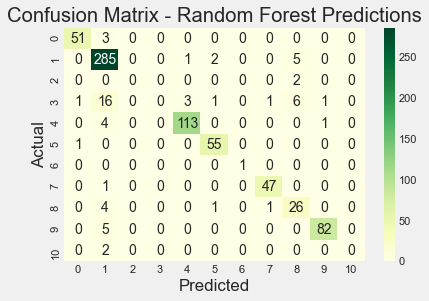

Learning curve plot: 0:00:20.360485 to generate


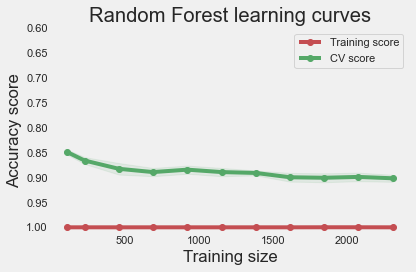

In [ ]:
#
from sklearn import ensemble
#
title = 'Random Forest'
#
rand_for = fit_classifier(clf = ensemble.RandomForestClassifier)
#param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100], 'max_features' :['sqrt', 'log2']}
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : n_estimators_by20, 'max_features' :['sqrt', 'log2']}
rand_for.grid_search(parameters = param_grid, Kfold = Kfold)
rand_for.grid_fit(X = X_train, Y = Y_train)
rand_for.grid_predict(X_test, Y_test)
# Confusion Matrix
plt.title('Confusion Matrix - ' + title + ' Predictions')
sns.heatmap(metrics.confusion_matrix(Y_test, rand_for.predictions), annot=True, cmap='YlGn', fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# Learning Curves
randfor_lc = plot_learning_curve(rand_for.grid.best_estimator_, title + ' learning curves', X_train, Y_train, ylim = ylim, cv = cv, train_sizes = train_sizes)

#### AdaBoost

Duration: 0:00:07.919798
Accuracy: 56.233%


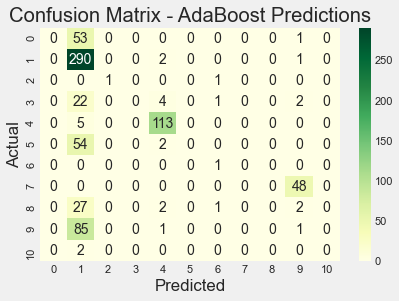

Learning curve plot: 0:00:08.444171 to generate


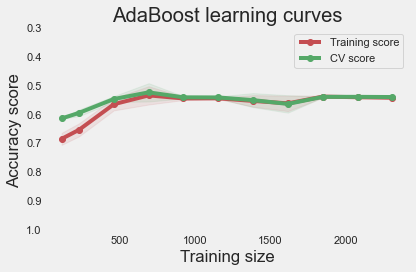

In [ ]:
#
from sklearn.ensemble import AdaBoostClassifier
#
ylim = [1.01, 0.3]
title = 'AdaBoost'
#
adaboost = fit_classifier(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : n_estimators}
adaboost.grid_search(parameters = param_grid, Kfold = Kfold)
adaboost.grid_fit(X = X_train, Y = Y_train)
adaboost.grid_predict(X_test, Y_test)
# Confusion Matrix
plt.title('Confusion Matrix - ' + title + ' Predictions')
sns.heatmap(metrics.confusion_matrix(Y_test, adaboost.predictions), annot=True, cmap='YlGn', fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# Learning Curves
adaboost_lc = plot_learning_curve(adaboost.grid.best_estimator_, title + ' learning curves', X_train, Y_train, ylim = ylim, cv = cv, train_sizes = train_sizes)

#### Gradient Boost

Duration: 0:01:44.109546
Accuracy: 90.166%


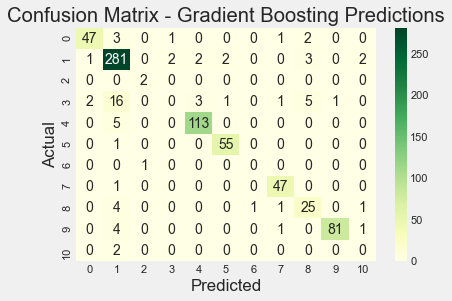

Learning curve plot: 0:01:36.478021 to generate


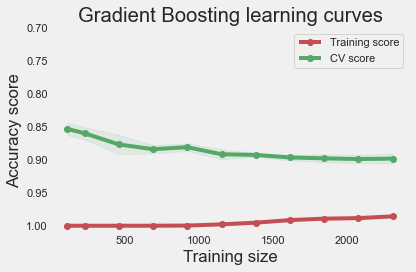

In [ ]:
#
ylim = [1.01, 0.7]
title = 'Gradient Boosting'
#
gboost = fit_classifier(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : n_estimators}
gboost.grid_search(parameters = param_grid, Kfold = Kfold)
gboost.grid_fit(X = X_train, Y = Y_train)
gboost.grid_predict(X_test, Y_test)
# Confusion Matrix
plt.title('Confusion Matrix - ' + title + ' Predictions')
sns.heatmap(metrics.confusion_matrix(Y_test, gboost.predictions), annot=True, cmap='YlGn', fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# Learning Curves
gboost_lc = plot_learning_curve(gboost.grid.best_estimator_, title + ' learning curves', X_train, Y_train, ylim = ylim, cv = cv, train_sizes = train_sizes)

### Voting Predictions

In [ ]:
# get best values of all params
rand_for_best  = ensemble.RandomForestClassifier(**rand_for.grid.best_params_)
gboost_best  = ensemble.GradientBoostingClassifier(**gboost.grid.best_params_)
tree_best  = tree.DecisionTreeClassifier(**m_tree.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
logreg_best  = linear_model.LogisticRegression(**logreg.grid.best_params_)

#
voting_clf = ensemble.VotingClassifier(
    estimators=[
        ('rand_forest', rand_for_best),
        ('gboost', gboost_best),
        ('decision_tree', tree_best),
        ('knn', knn_best),
        ('logreg', logreg_best),
    ],
    voting='soft')

In [ ]:
voting_clf = voting_clf.fit(X_train, Y_train)

In [ ]:
voting_predictions = voting_clf.predict(X_test)
print('Precision: {:.2f} % '.format(100*metrics.accuracy_score(Y_test, voting_predictions)))

Precision: 91.41 % 


In [ ]:
test_invoice_total = test_set.copy()

orders_per_customer=test_invoice_total.groupby(by=['CustomerID'])['Invoice_Total'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = prod_cat_n.format(i)
    orders_per_customer.loc[:,col] = test_invoice_total.groupby(by=['CustomerID'])[col].sum() / orders_per_customer['sum']*100

orders_per_customer.reset_index(drop = False, inplace = True)
test_invoice_total.groupby(by=['CustomerID'])['prod_cat_0'].sum()

#
# Correcting time range
orders_per_customer['count'] = 5 * orders_per_customer['count']
orders_per_customer['sum']   = orders_per_customer['count'] * orders_per_customer['mean']

orders_per_customer.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4
0,12347,10,224.82,1294.32,759.57,7595.70,12.696657,32.343299,24.271627,20.017905,10.670511
1,12349,5,1757.55,1757.55,1757.55,8787.75,4.513101,12.245455,10.713778,26.506216,46.021450
2,12352,5,311.73,311.73,311.73,1558.65,6.672441,8.735123,7.217785,34.420813,42.953838
3,12356,5,58.35,58.35,58.35,291.75,0.000000,0.000000,0.000000,0.000000,100.000000
4,12357,5,6207.67,6207.67,6207.67,31038.35,5.089832,14.684737,28.350089,18.475531,33.399810


In [ ]:
feature_list = feature_cols + category_cols
test_matrix = orders_per_customer[feature_list].values
scaled_test_matrix = scaler.transform(test_matrix)

Y = kmeans.predict(scaled_test_matrix)

x_feature_list = ['mean'] + category_cols
X = orders_per_customer[x_feature_list]

#### Prediction via Test Data


Support Vector Machine
Accuracy: 72.016%


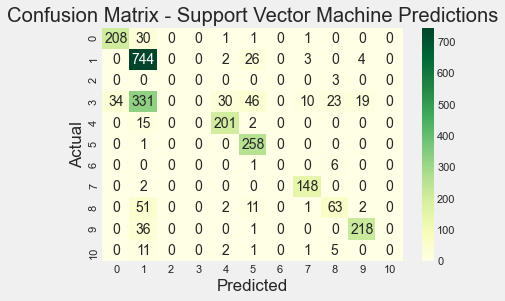

Learning curve plot: 0:00:08.579015 to generate


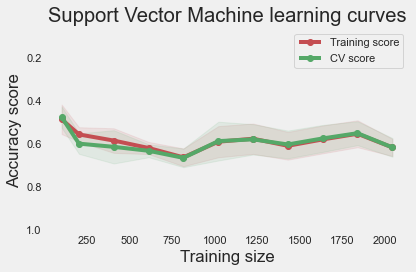


Logostic Regression
Accuracy: 75.460%


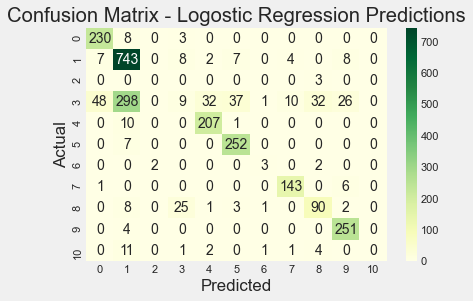

Learning curve plot: 0:00:03.454630 to generate


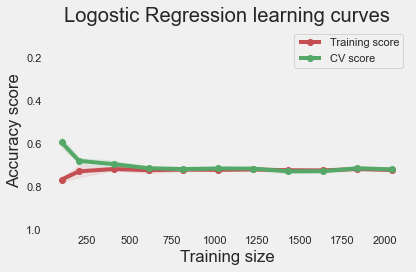


k-Nearest Neighbors
Accuracy: 67.241%


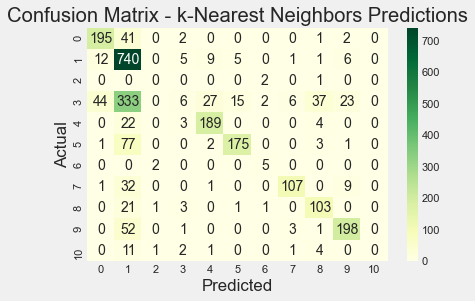

Learning curve plot: 0:00:02.397452 to generate


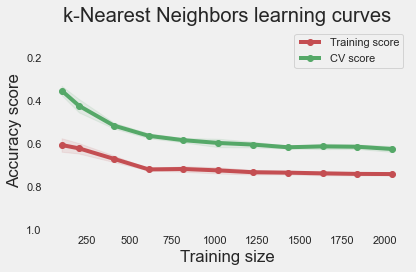


Decision Tree
Accuracy: 69.941%


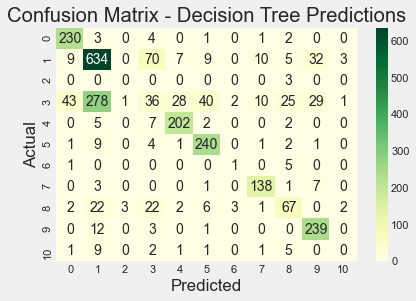

Learning curve plot: 0:00:00.389754 to generate


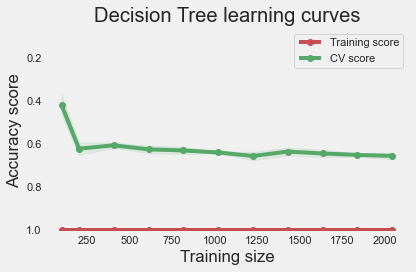


Random Forest
Accuracy: 75.734%


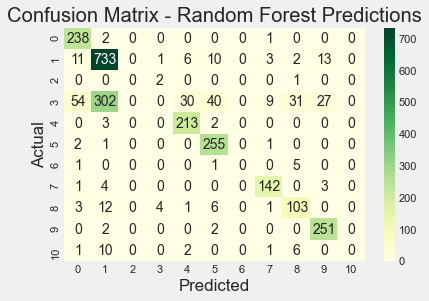

Learning curve plot: 0:00:20.227799 to generate


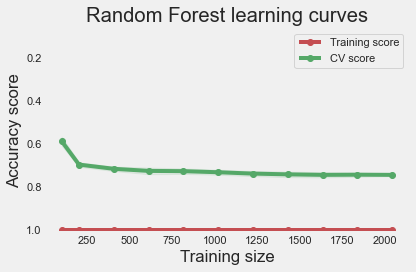


Gradient Boosting
Accuracy: 76.164%


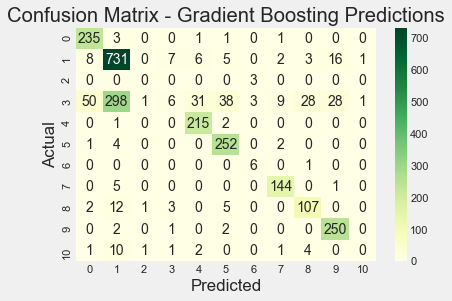

Learning curve plot: 0:01:28.072027 to generate


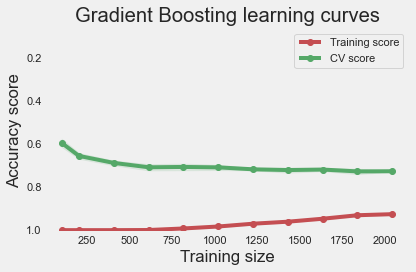

In [ ]:
# Build list of classifiers
clfs = [
    (svc, 'Support Vector Machine'),
    (logreg, 'Logostic Regression'),
    (knn, 'k-Nearest Neighbors'),
    (m_tree, 'Decision Tree'),
    (rand_for, 'Random Forest'),
    (gboost, 'Gradient Boosting')
]

#
ylim = [1.01, 0.06]

#
for clf, title in clfs:
    print('\n{}'.format(title))
    clf.grid_predict(X, Y)
    # Confusion Matrix
    plt.title('Confusion Matrix - ' + title + ' Predictions')
    sns.heatmap(metrics.confusion_matrix(Y, clf.predictions), annot=True, cmap='YlGn', fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    # Learning Curves
    p = plot_learning_curve(clf.grid.best_estimator_, title + ' learning curves', X, Y, ylim = ylim, cv = cv, train_sizes = train_sizes)
    plt.show()

In [ ]:
voting_predictions = voting_clf.predict(X)
print('Precision: {:.2f} % '.format(100*metrics.accuracy_score(Y, voting_predictions)))

Precision: 76.28 % 
